In [7]:
# 1.对数据集进行处理，转换成适合进行关联规则挖掘的形式
# ------------------------------------------------
import pandas as pd
path = './winemag-data_first150k.csv'
data = pd.read_csv(path)

# 处理country空值，根据designation确定对应country
designation2country = {
    "Askitikos":"Greece",    
    "Shah":"US",
    "Piedra Feliz":"Chile",
}
for i in range(len(data)):
    country = data.iloc[i,1]
    if pd.isnull(country):
        designation = data.iloc[i,3]
        data.iloc[i,1] = designation2country[designation]

# 将price和points进行离散化
def points_discretization(value):
    return "points-" + str(int(value/5))

data.loc[:,'points'] = data['points'].map(lambda x:points_discretization(x))

def price_discretization(value):
    if value < 100:
        return "price-" + str(int(value/10))
    else:
        return "price-" + "10"

data.loc[:,'price'] = data['price'].map(lambda x:price_discretization(x))

# 仅保留country、points、price用于分析
data = data.drop(['Unnamed: 0','description','province','region_1', \
                'region_2','variety','winery','designation'], axis = 1)

# 数据格式转换
def deal(data):
    return data.to_list()
data = data.apply(deal,axis=1).tolist()
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
tf = te.fit_transform(data)
new_data = pd.DataFrame(tf,columns=te.columns_)

In [9]:
# 2.找出频繁模式
# ------------------------------------------------
# 使用apriori算法，找出频繁模式
from mlxtend.frequent_patterns import apriori
min_support = 0.03      # 最小支持度阈值取0.03
apriori_result = apriori(new_data, min_support=min_support, use_colnames=True, max_len=4) \
        .sort_values(by='support', ascending=False)
apriori_result

,support,itemsets
9,0.526887,(points-17)
7,0.413423,(US)
12,0.303419,(price-1)
10,0.299669,(points-18)
14,0.212986,(price-2)
37,0.201034,"(points-17, price-1)"
29,0.199788,"(points-17, US)"
4,0.155556,(Italy)
8,0.153694,(points-16)
3,0.139787,(France)


In [10]:
# 3.导出关联规则，计算其支持度和置信度
# ------------------------------------------------
# 使用association_rules方法，导出关联规则，同时获得支持度及置信度
from mlxtend.frequent_patterns import association_rules
min_threshold = 0.4     # 置信度阈值设为0.4
rules =  association_rules(apriori_result, metric ='confidence',min_threshold = min_threshold)
rules = rules.drop(['leverage','conviction'], axis = 1)

# 输出支持度、置信度
for index, row in rules.iterrows():
    #print(row)
    antecedents = tuple(row['antecedents'])
    consequents = tuple(row['consequents'])
    print("%s ⇒ %s (suupport = %f, confidence = %f )" % (antecedents, consequents, \
          row['support'], row['confidence']))

('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
('US',) ⇒ ('points-17',) (suupport = 0.199788, confidence = 0.483253 )
('price-2',) ⇒ ('points-17',) (suupport = 0.131604, confidence = 0.617900 )
('points-18',) ⇒ ('US',) (suupport = 0.128748, confidence = 0.429636 )
('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
('Italy',) ⇒ ('points-17',) (suupport = 0.093964, confidence = 0.604055 )
('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
('France',) ⇒ ('points-17',) (suupport = 0.066998, confidence = 0.479287 )
('price-3',) ⇒ ('points-17',) (suupport = 0.062327, confidence = 0.500399 )
('points-17', 'price-2') ⇒ ('US',) (suupport = 0.060757, confidence = 0.461662 )
('US', 'price-2') ⇒ ('points-17',) (suupport = 0.060757, confidence = 0.570700 )
('US', 'price-1') ⇒ ('points-17',)

In [12]:
# 4.对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种
# ------------------------------------------------
# 这里使用提升度Lift和全置信度allconf
def allconf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])
allconf_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
rules['allconf'] = allconf_list
rules.drop(['antecedent support','consequent support'],axis=1,inplace=False)
final_rules = rules.iloc[:]
from sklearn.preprocessing import LabelEncoder
for index, row in final_rules.iterrows():
    #print(row)
    if row['allconf'] < 0.1:    # 过滤allconf小于0.1的规则
        final_rules.drop(index=index,inplace=True) 
final_rules = final_rules.sort_values(by=['lift'], ascending=False)[:16] # 按照lift从大到小排序取前16项

final_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
16,(price-10),(France),0.118121,0.139787,0.049930,0.422706,3.023936,0.357190
27,(price-5),(points-18),0.049990,0.299669,0.030405,0.608217,2.029632,0.101461
19,(price-4),(points-18),0.082840,0.299669,0.043855,0.529393,1.766594,0.146344
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132,0.185727
22,"(points-16, US)",(price-1),0.076048,0.303419,0.033936,0.446245,1.470723,0.111846
14,(price-10),(points-18),0.118121,0.299669,0.051898,0.439365,1.466169,0.173185
17,(price-4),(US),0.082840,0.413423,0.049692,0.599856,1.450948,0.120196
15,(price-3),(points-18),0.124554,0.299669,0.049990,0.401351,1.339316,0.166818
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503,0.381550


In [15]:
# 5.对挖掘结果进行分析
# ------------------------------------------------
idx = 0
for _, row in final_rules.iterrows():
    idx += 1
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%d : %s ⇒ %s (support = %f, confidence = %f )"%(idx,t1,t2,row['support'],row['confidence']))

1 : ('price-10',) ⇒ ('France',) (support = 0.049930, confidence = 0.422706 )
2 : ('price-5',) ⇒ ('points-18',) (support = 0.030405, confidence = 0.608217 )
3 : ('price-4',) ⇒ ('points-18',) (support = 0.043855, confidence = 0.529393 )
4 : ('points-16',) ⇒ ('price-1',) (support = 0.079454, confidence = 0.516963 )
5 : ('price-3',) ⇒ ('US',) (support = 0.076784, confidence = 0.616469 )
6 : ('points-16', 'US') ⇒ ('price-1',) (support = 0.033936, confidence = 0.446245 )
7 : ('price-10',) ⇒ ('points-18',) (support = 0.051898, confidence = 0.439365 )
8 : ('price-4',) ⇒ ('US',) (support = 0.049692, confidence = 0.599856 )
9 : ('price-3',) ⇒ ('points-18',) (support = 0.049990, confidence = 0.401351 )
10 : ('price-1',) ⇒ ('points-17',) (support = 0.201034, confidence = 0.662561 )
11 : ('price-2',) ⇒ ('US',) (support = 0.106460, confidence = 0.499844 )
12 : ('points-16',) ⇒ ('US',) (support = 0.076048, confidence = 0.494805 )
13 : ('price-2',) ⇒ ('points-17',) (support = 0.131604, confidence = 0.

根据规则挖掘结果，可以发现以下信息：
- 法国的葡萄酒价格较高（由1可得）
- 葡萄酒价格和评分成正相关（由2，3，4，7，9，10，13可得）
- 美国的葡萄酒价格分布较为广泛（由5，6，8，12，15，16可得）

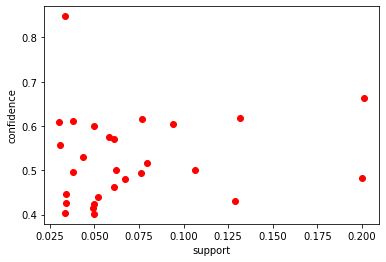

In [16]:
# 5.可视化展示
# ------------------------------------------------
import  matplotlib.pyplot as plt

# 支持度与置信度关联关系展示
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='r')

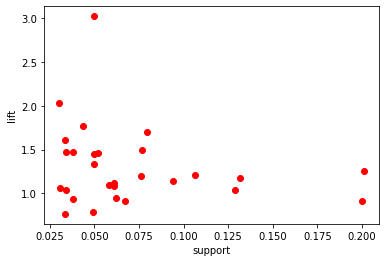

In [17]:
# 支持度与lift关联关系展示
plt.xlabel('support')
plt.ylabel('lift')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.lift[i],c='r')